In [18]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [110]:
unet = tf.keras.models.load_model('model.h5', compile=False)

image_gray = np.load("D:/fin_de_etude/data/dataset_2d/nodule/image2_slice32.npy")
image_gray = image_gray/255
y_1 = unet.predict(image_gray.reshape((1,512,512,1)))
y_1 = np.where(y_1>0.5,1,0)


1/1 [==============================] - 0s 127ms/step


In [111]:
deeplab = tf.keras.models.load_model('deeplabv3plus.h5', compile=False)

image_gray = np.load("D:/fin_de_etude/data/dataset_2d/nodule/image2_slice32.npy")
image_gray = image_gray/255
y_2 = deeplab.predict(image_gray.reshape((1,512,512,1)))
y_2 = np.where(y_1>0.5,1,0)



1/1 [==============================] - 0s 186ms/step


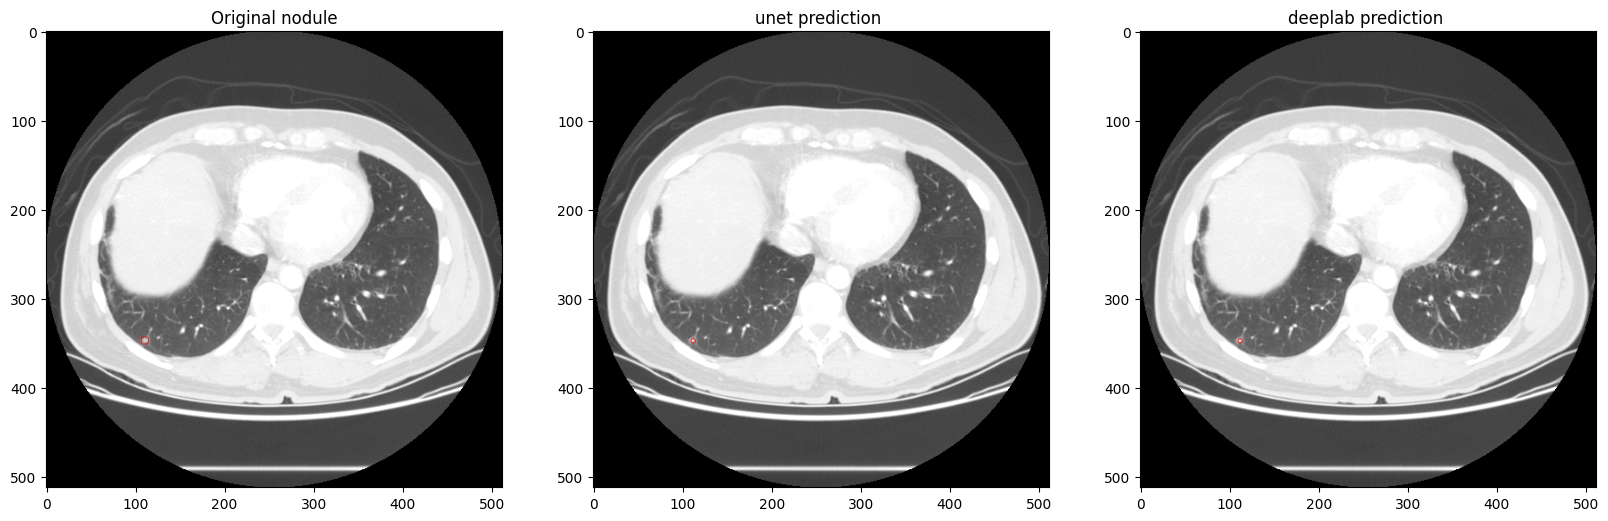

In [112]:
mask = np.load("D:/fin_de_etude/data/nodule_mask/nodule/image2_slice32.npy")
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(20, 20))
ax1.imshow(image_gray,cmap="gray" )
ax1.set_title('Original nodule')
ax2.imshow(image_gray,cmap='gray')
ax2.set_title('unet prediction ')
ax3.imshow(image_gray,cmap='gray')
ax3.set_title('deeplab prediction ')
ax1.contour(mask.reshape((512,512)), levels=[0.4], colors='r', linewidths=0.5)
ax2.contour(y_1.reshape((512,512)), levels=[0.4], colors='r', linewidths=0.5)
ax3.contour(y_2.reshape((512,512)), levels=[0.4], colors='r', linewidths=0.5)

plt.show()

In [118]:
import numpy as np
from skimage import measure
import cv2
import pandas as ad
# Load the mask image


# Find contours in the mask
contours = measure.find_contours(mask, 0.1)

# Loop through the contours and extract the circle properties
for cnt in contours:
    # Convert the contour to integer format
    cnt = np.array(cnt, dtype=np.int32)
    
    # Fit a circle to the contour using the minimum enclosing circle method
    (y, x), radius = cv2.minEnclosingCircle(cnt)
    center = (x,y)
    diameter = radius * 2
    
    # Print the circle properties
    
    print('Center:', center)
    print('Diameter:', diameter)

Center: (110.0, 346.3571472167969)
Diameter: 9.588665962219238


In [115]:
df = ad.read_csv("D:/fin_de_etude/data/pfe/data preprocessing/annotation_2.csv")
df = df[df["seriesuid"]=="image2_slice32"]
print(df)

    Unnamed: 0       seriesuid      coordX      coordY     coordZ  diameter_mm
23          23  image2_slice32  110.392593  346.624474  32.773352     8.678231


109 343
